LSTM + Pytorch For User Stories Classification

1.1 Preprocess the data

In [1]:
from nltk.corpus import stopwords
from nltk import word_tokenize
import torch
#read dataset
import pandas as pd
df = pd.read_csv('dataset/user_stories_data.csv')
text_data = df['texts'].tolist()
label_data = df['labels'].tolist()

from transformers import BertTokenizer, BertModel
import torch
#use GPU to run it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {'GPU' if device.type == 'cuda' else 'CPU'}")

#get word embedding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)
sentence_embeddings=[]
for text in text_data:
    bert_input = tokenizer(text,padding='max_length',
                       max_length = 10,
                       truncation=True,
                       return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(**bert_input)
    hidden_states = output.last_hidden_state
    sentence_embedding = hidden_states[:,0,:].squeeze()# get the [CLS] as the sentence embedding
    sentence_embeddings.append(sentence_embedding)

Using GPU


1.2 Training : LSTM

Epoch 1, Loss: 1.6594740529603595
Epoch 2, Loss: 1.4514347918425934
Epoch 3, Loss: 1.3270667881905278
Epoch 4, Loss: 1.2687586719476724
Epoch 5, Loss: 1.2264407058305378
Epoch 6, Loss: 1.1816313553460036
Epoch 7, Loss: 1.1524285998525499
Epoch 8, Loss: 1.129708231249942
Epoch 9, Loss: 1.108696845513356
Epoch 10, Loss: 1.0926027365877657
Epoch 11, Loss: 1.067932764940624
Epoch 12, Loss: 1.052109259593336
Epoch 13, Loss: 1.0492842725560636
Epoch 14, Loss: 1.0265795792205423
Epoch 15, Loss: 1.0079390248165856
Epoch 16, Loss: 0.995056027098547
Epoch 17, Loss: 0.9733045848110055
Epoch 18, Loss: 0.9646048625058765
Epoch 19, Loss: 0.9536333680152893
Epoch 20, Loss: 0.9557653122310397
Epoch 21, Loss: 0.9318298199508763
Epoch 22, Loss: 0.9159824667097647
Epoch 23, Loss: 0.9107778132716312
Epoch 24, Loss: 0.9132092391388326
Epoch 25, Loss: 0.899318775798701
Epoch 26, Loss: 0.8954044422016868
Epoch 27, Loss: 0.8678711132158207
Epoch 28, Loss: 0.8812092497378965
Epoch 29, Loss: 0.8625305144092704


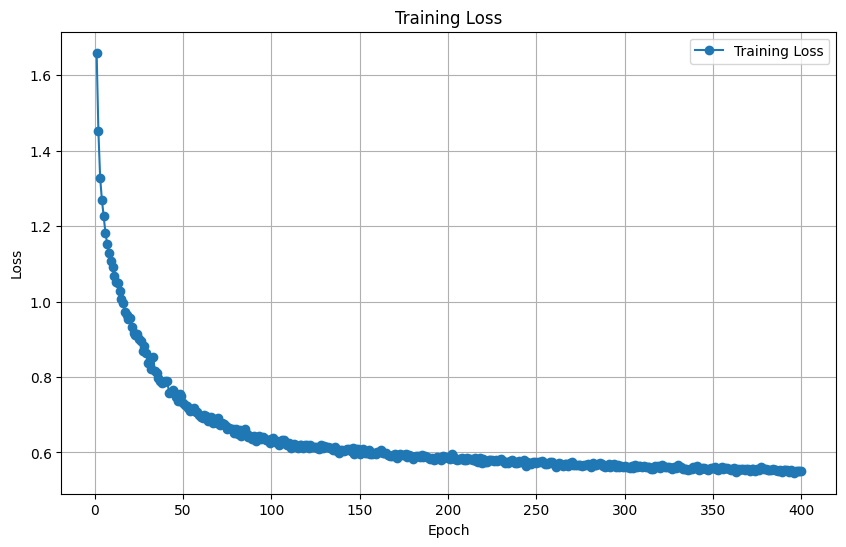

In [4]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn  # 正确导入 torch.nn 并简称为 nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# label data set
labels = {'Usability':0,
          'Functional':1,
          'Maintainability':2,
          'Security':3,
          'Portability':4,
          'Performance':5,
          'Compatibility':6,
          'Reliability':7
          }
labels_data = [labels[label] for label in label_data]


class BERT_LSTM_Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional=True, dropout=0.5):
        super(BERT_LSTM_Classifier, self).__init__()
        # LSTM层
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)
        # 定向设置
        self.directions = 2 if bidirectional else 1
        # 全连接层
        self.fc = nn.Linear(hidden_dim * self.directions, output_dim)
        # LogSoftmax层
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs):

        # LSTM层
        lstm_out, _ = self.lstm(inputs)

        # 通过全连接层
        out = self.fc(lstm_out)
        # LogSoftmax
        out = self.log_softmax(out)
        return out





# load dataset and label
from torch.utils.data import TensorDataset, DataLoader
sentence_embeddings_tensor = torch.stack(sentence_embeddings)
labels_tensor = torch.tensor(labels_data)

X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings_tensor, labels_tensor, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 模型参数
embedding_dim = 768
hidden_dim = 256
output_dim = len(labels)  
num_epochs = 400 




model = BERT_LSTM_Classifier(embedding_dim=embedding_dim,
                             hidden_dim=hidden_dim,
                             output_dim=output_dim,
                             num_layers=1,  # 根据需要调整层数
                             bidirectional=False,  # 根据需要选择是否双向
                             dropout=0.1).to(device)

#loss function
loss_fn = nn.NLLLoss()  # 因为模型最后一层是LogSoftmax
optimizer = optim.Adam(model.parameters())


#train
model.train()
epoch_losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader)}")

# 测试循环
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {correct / total * 100:.2f}%")

import matplotlib.pyplot as plt

# 绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

Finetuning Bert Model

In [3]:
# class BertForUserStories(torch.nn.Module):
#     def __init__(self,bert_model,num_labels):
#         super(BertForUserStories, self).__init__()
#         self.bert = bert_model
#         self.classifier = torch.nn.Linear(bert_model.config.hidden_size, num_labels)
#     def forward(self,input_ids,attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         cls_output = outputs.pooler_output  # 使用CLS标记的输出
#         logits = self.classifier(cls_output)
#         return logits
#
#
# input_ids = tokenizer(sentence_embeddings_tensor, padding=True, truncation=True, return_tensors="pt")["input_ids"]
# attention_mask = tokenizer(labels_tensor, padding=True, truncation=True, return_tensors="pt")["attention_mask"]
#
# train_dataset = TensorDataset(input_ids, attention_mask, torch.tensor(y_train))
# train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
#
# num_labels = 8
# model = BertForSentenceEmbedding(model, num_labels=num_labels).to(device)
# optimizer = AdamW(model.parameters(), lr=5e-5)
# model.train()
# for batch in train_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
#     labels = batch[2]
#
#     optimizer.zero_grad()
#     outputs = model(**inputs)
#     loss = torch.nn.functional.cross_entropy(outputs, labels)
#     loss.backward()
#     optimizer.step()